### **코드 구동 전에 꼭 주석해제하고 설치해주세요! 설치 후에는 주석 처리 권장**

In [1076]:
# !pip show scipy
# !pip install nltk
# !pip install pandas
# !pip install contractions
# import nltk # 수정 감사합니다~
# nltk.download('punkt') # 오래 걸림..
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# !pip install pyLDAvis
# !pip install gensim
# !pip install scikit-learn

In [1077]:
from sklearn.cluster import KMeans

### 사용 라이브러리들

In [1078]:
import re
import os
import nltk
import string
import gensim
import pyLDAvis
import numpy as np
import contractions
import pandas as pd
from tqdm import tqdm
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim as gensimvis
from matplotlib import pyplot as plt
from gensim import corpora, models
from gensim.models import doc2vec
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.doc2vec import TaggedDocument
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer

pd.set_option('display.max_columns', None) # Pandas 전체 열 확인
pd.set_option('display.max_rows', None) # Pandas 전체 행 확인

### 1. 데이터 로딩

In [1079]:
# df = pd.read_csv("./LDA-Workspace/1. Data/Flipkart/df_LG_refri.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
# df = pd.read_csv("./1. Data/Amazon/Amazon_LG_TV_review.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df = pd.read_csv("./1. Data/Flipkart_state/LG_air_state.csv") # 로드할 데이터의 (상대 or 절대) 경로를 지정
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,Waste of money . AC not working till one month...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Alwar,"May, 2023","TS-Q18JNXE3, Copper Condenser",Alwar
1,1,I purchased this LG A. C. on 17 April 23..The ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Kalyan,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Kalyan
2,2,If you want to buy a white showpiece for your ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Madhyamgram,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Madhyamgram
3,3,Totally waste of money. company is not refund ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Charkhi Dadri,"May, 2022","TS-Q18JNXE3, Copper Condenser",Charkhi Dadri
4,4,"This model don't have 4 way swing, it's actual...",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Erode,"Feb, 2024","TS-Q18JNXE3, Copper Condenser",Erode


In [1080]:
# df = df[(df['star'] == 1) | (df['star'] == 2)]

#### 옵션) 별점, 지역 등을 기준으로 필터링하실 분들은 아래에 코드 추가해서 진행 바랍니다

In [1081]:
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,Waste of money . AC not working till one month...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Alwar,"May, 2023","TS-Q18JNXE3, Copper Condenser",Alwar
1,1,I purchased this LG A. C. on 17 April 23..The ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Kalyan,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Kalyan
2,2,If you want to buy a white showpiece for your ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Madhyamgram,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Madhyamgram
3,3,Totally waste of money. company is not refund ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Charkhi Dadri,"May, 2022","TS-Q18JNXE3, Copper Condenser",Charkhi Dadri
4,4,"This model don't have 4 way swing, it's actual...",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Erode,"Feb, 2024","TS-Q18JNXE3, Copper Condenser",Erode


In [1082]:
# df = df[df["star"] == 5] # 예시. 별점으로 분류할 경우
# df.head()

### 2. 데이터 전처리
1. 결측 데이터 여부 확인
1-2. 결측 데이터 확인시 다른 데이터(공백이나 0 등)로 대체
2. 이모지 제거 -> 텍스트 전처리 시작
3. 소문자 변환 
4. 수축형 확장
5. 구두점 제거
6. 불용어 제거
7. 표제어 추출
8. 단일 글자 제거
9. 숫자 제거

---
- 특정 데이터만 전처리를 원할 경우 코드 수정해서 사용해주세요! (예. df['특정열'])

In [1083]:
# 로딩한 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1244 non-null   int64 
 1   text              1244 non-null   object
 2   star              1244 non-null   int64 
 3   hp_data           1244 non-null   object
 4   city              1242 non-null   object
 5   transformed_date  1244 non-null   object
 6   product_num       1244 non-null   object
 7   state             1242 non-null   object
dtypes: int64(2), object(6)
memory usage: 77.9+ KB


#### 1) 결측 데이터 여부 확인

In [1084]:
df.isnull().sum()

Unnamed: 0          0
text                0
star                0
hp_data             0
city                2
transformed_date    0
product_num         0
state               2
dtype: int64

#### 1-2) 결측 데이터 대체
- 임시 방안

In [1085]:
df = df.fillna('') # 결측치가 있는 경우
df.isnull().sum() # 결측치 데이터 여부 재확인

Unnamed: 0          0
text                0
star                0
hp_data             0
city                0
transformed_date    0
product_num         0
state               0
dtype: int64

#### 2) 이모지 제거
- 영어 제외 언어들도 제거?
  - 아스키(American ~) 코드를 기준으로 제거했기 때문에 다른 언어들도 함께 제거되는 것으로 추정

In [1086]:
# 텍스트에서 이모지를 제거하는 함수
# 아스키 코드로 변환 후 제거
def rmEmoji_ascii(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# DataFrame의 모든 문자열에 적용
def df_remove_emoji(df):
    return df.map(lambda x: rmEmoji_ascii(x) if isinstance(x, str) else x)

In [1087]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,Waste of money . AC not working till one month...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Alwar,"May, 2023","TS-Q18JNXE3, Copper Condenser",Alwar
1,1,I purchased this LG A. C. on 17 April 23..The ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Kalyan,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Kalyan
2,2,If you want to buy a white showpiece for your ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Madhyamgram,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Madhyamgram
3,3,Totally waste of money. company is not refund ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Charkhi Dadri,"May, 2022","TS-Q18JNXE3, Copper Condenser",Charkhi Dadri
4,4,"This model don't have 4 way swing, it's actual...",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Erode,"Feb, 2024","TS-Q18JNXE3, Copper Condenser",Erode


In [1088]:
# After
df = df_remove_emoji(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,Waste of money . AC not working till one month...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Alwar,"May, 2023","TS-Q18JNXE3, Copper Condenser",Alwar
1,1,I purchased this LG A. C. on 17 April 23..The ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Kalyan,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Kalyan
2,2,If you want to buy a white showpiece for your ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Madhyamgram,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Madhyamgram
3,3,Totally waste of money. company is not refund ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Charkhi Dadri,"May, 2022","TS-Q18JNXE3, Copper Condenser",Charkhi Dadri
4,4,"This model don't have 4 way swing, it's actual...",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Erode,"Feb, 2024","TS-Q18JNXE3, Copper Condenser",Erode


#### 3) 소문자 변환

In [1089]:
# DataFrame의 모든 열에 대해 문자열을 소문자로 변환하는 함수
# 문자열이 아닌 경우는 그대로 유지
def df_lowercase(df):
    return df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [1090]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,Waste of money . AC not working till one month...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Alwar,"May, 2023","TS-Q18JNXE3, Copper Condenser",Alwar
1,1,I purchased this LG A. C. on 17 April 23..The ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Kalyan,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Kalyan
2,2,If you want to buy a white showpiece for your ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Madhyamgram,"Apr, 2023","TS-Q18JNXE3, Copper Condenser",Madhyamgram
3,3,Totally waste of money. company is not refund ...,1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Charkhi Dadri,"May, 2022","TS-Q18JNXE3, Copper Condenser",Charkhi Dadri
4,4,"This model don't have 4 way swing, it's actual...",1,LG AI Convertible 6-in-1 Cooling 2024 Model 1....,Erode,"Feb, 2024","TS-Q18JNXE3, Copper Condenser",Erode


In [1091]:
# After
df = df_lowercase(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money . ac not working till one month...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,alwar,"may, 2023","ts-q18jnxe3, copper condenser",alwar
1,1,i purchased this lg a. c. on 17 april 23..the ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,kalyan,"apr, 2023","ts-q18jnxe3, copper condenser",kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,madhyamgram,"apr, 2023","ts-q18jnxe3, copper condenser",madhyamgram
3,3,totally waste of money. company is not refund ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,charkhi dadri,"may, 2022","ts-q18jnxe3, copper condenser",charkhi dadri
4,4,"this model don't have 4 way swing, it's actual...",1,lg ai convertible 6-in-1 cooling 2024 model 1....,erode,"feb, 2024","ts-q18jnxe3, copper condenser",erode


#### 4) 수축형 확장
- don't -> do not, aren't -> are not, etc 

In [1092]:
# DataFrame의 모든 문자열 열에서 수축형을 확장하는 함수.
# 문자열이 아닌 경우는 그대로 유지
def df_expand_contractions(df):
     return df.map(lambda x: contractions.fix(x) if isinstance(x, str) else x)

In [1093]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money . ac not working till one month...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,alwar,"may, 2023","ts-q18jnxe3, copper condenser",alwar
1,1,i purchased this lg a. c. on 17 april 23..the ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,kalyan,"apr, 2023","ts-q18jnxe3, copper condenser",kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,madhyamgram,"apr, 2023","ts-q18jnxe3, copper condenser",madhyamgram
3,3,totally waste of money. company is not refund ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,charkhi dadri,"may, 2022","ts-q18jnxe3, copper condenser",charkhi dadri
4,4,"this model don't have 4 way swing, it's actual...",1,lg ai convertible 6-in-1 cooling 2024 model 1....,erode,"feb, 2024","ts-q18jnxe3, copper condenser",erode


In [1094]:
# After
df = df_expand_contractions(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money . ac not working till one month...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,alwar,"may, 2023","ts-q18jnxe3, copper condenser",alwar
1,1,i purchased this lg a. c. on 17 april 23..the ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,kalyan,"apr, 2023","ts-q18jnxe3, copper condenser",kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,madhyamgram,"apr, 2023","ts-q18jnxe3, copper condenser",madhyamgram
3,3,totally waste of money. company is not refund ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,charkhi dadri,"may, 2022","ts-q18jnxe3, copper condenser",charkhi dadri
4,4,"this model do not have 4 way swing, it is actu...",1,lg ai convertible 6-in-1 cooling 2024 model 1....,erode,"feb, 2024","ts-q18jnxe3, copper condenser",erode


#### 5) 구두점 제거
- ?,!. 과 같이 텍스트 분석에 불필요한 요소들 제거
- 필요시, 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [1095]:
def df_remove_punctuation(df):
    return df.map(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if isinstance(x, str) else x)

In [1096]:
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money . ac not working till one month...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,alwar,"may, 2023","ts-q18jnxe3, copper condenser",alwar
1,1,i purchased this lg a. c. on 17 april 23..the ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,kalyan,"apr, 2023","ts-q18jnxe3, copper condenser",kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,madhyamgram,"apr, 2023","ts-q18jnxe3, copper condenser",madhyamgram
3,3,totally waste of money. company is not refund ...,1,lg ai convertible 6-in-1 cooling 2024 model 1....,charkhi dadri,"may, 2022","ts-q18jnxe3, copper condenser",charkhi dadri
4,4,"this model do not have 4 way swing, it is actu...",1,lg ai convertible 6-in-1 cooling 2024 model 1....,erode,"feb, 2024","ts-q18jnxe3, copper condenser",erode


In [1097]:
df = df_remove_punctuation(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money ac not working till one month ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,i purchased this lg a c on 17 april 23the most...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste of money company is not refund m...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,this model do not have 4 way swing it is actua...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


#### 6) 불용어 제거
- nltk 불용어 사전 적용

In [1098]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money ac not working till one month ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,i purchased this lg a c on 17 april 23the most...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste of money company is not refund m...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,this model do not have 4 way swing it is actua...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


In [1099]:
# 불용어 목록 가져오기
stop_words = set(stopwords.words('english'))

In [1100]:
# 불용어 제거 함수
def remove_stopwords(text):
    if isinstance(text, str):
        words = word_tokenize(text)  # 텍스트를 단어로 토큰화
        filtered_words = [word for word in words if word.lower() not in stop_words]  # 불용어 제거
        return ' '.join(filtered_words)  # 필터링된 단어들을 다시 하나의 문자열로 결합
    else:
        return text  # 문자열이 아닌 경우 그대로 반환

def df_remove_stopwords(df):
    return df.map(remove_stopwords)

In [1101]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste of money ac not working till one month ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,i purchased this lg a c on 17 april 23the most...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,if you want to buy a white showpiece for your ...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste of money company is not refund m...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,this model do not have 4 way swing it is actua...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


In [1102]:
# After
df = df_remove_stopwords(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac working till one month installa...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,purchased lg c 17 april 23the horrible experie...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,model 4 way swing actual ton 13 cooling capaci...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


#### 7) 표제어 추출
- 단어 원형 추출
  - children -> child, went -> go, etc

In [1103]:
# nltk의 pos_tag와 wordnet의 태그 매핑 함수
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# 모든 문자열에 대해 표제어 추출을 수행하는 함수
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer() # 텍스트를 토큰화
    tokens = word_tokenize(text) # 품사 태깅
    tagged_tokens = nltk.pos_tag(tokens) # 각 단어를 표제어 추출 (품사 정보 고려)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # 기본적으로 명사 처리
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=wordnet_pos))
    return ' '.join(lemmatized_tokens)

# DataFrame의 모든 문자열에 대해 lemmatize_text 함수 수행
# 문자열이 아닌 경우는 그대로 유지
def df_lemmatize(df):
    return df.map(lambda x: lemmatize_text(x) if isinstance(x, str) else x)

In [1104]:
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac working till one month installa...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,purchased lg c 17 april 23the horrible experie...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,model 4 way swing actual ton 13 cooling capaci...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


In [1105]:
# After
df = df_lemmatize(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,purchase lg c 17 april 23the horrible experien...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,model 4 way swing actual ton 13 cooling capaci...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


#### 8) 숫자 데이터 제거
- 마찬가지로 필요시 해당 부분은 일부 데이터를 제외하고 적용되도록 수정해서 사용 요망..(날짜, 모델명 등)

In [1106]:
# 숫자 제거 함수
def remove_numbers_from_text(text):
    cleaned_text = re.sub(r'\d+', '', text) # 숫자를 제거
    
    # 중복된 공백 제거 및 텍스트 정리
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text if cleaned_text else ""

def df_remove_numbers(df):
    return df.map(lambda x: remove_numbers_from_text(x) if isinstance(x, str) else x)

In [1107]:
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,alwar,may 2023,tsq18jnxe3 copper condenser,alwar
1,1,purchase lg c 17 april 23the horrible experien...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,kalyan,apr 2023,tsq18jnxe3 copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,madhyamgram,apr 2023,tsq18jnxe3 copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,charkhi dadri,may 2022,tsq18jnxe3 copper condenser,charkhi dadri
4,4,model 4 way swing actual ton 13 cooling capaci...,1,lg ai convertible 6in1 cooling 2024 model 15 t...,erode,feb 2024,tsq18jnxe3 copper condenser,erode


In [1108]:
df = df_remove_numbers(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,lg ai convertible in cooling model ton star sp...,alwar,may,tsqjnxe copper condenser,alwar
1,1,purchase lg c april the horrible experience ev...,1,lg ai convertible in cooling model ton star sp...,kalyan,apr,tsqjnxe copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible in cooling model ton star sp...,madhyamgram,apr,tsqjnxe copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible in cooling model ton star sp...,charkhi dadri,may,tsqjnxe copper condenser,charkhi dadri
4,4,model way swing actual ton cooling capacity w ...,1,lg ai convertible in cooling model ton star sp...,erode,feb,tsqjnxe copper condenser,erode


#### 9) 의미 없는 단일 글자 데이터 제거

In [1109]:
# 정규 표현식을 사용하여 한 글자 단어를 제거
def remove_single_characters(text):
    cleaned_text = re.sub(r'\b\w{1}\b', '', text)
    # 중복된 공백 제거
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# 마찬가지로 DataFrame에 적용
def df_remove_single_characters(df):
    return df.map(lambda x: remove_single_characters(x) if isinstance(x, str) else x)

In [1110]:
# Before
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,lg ai convertible in cooling model ton star sp...,alwar,may,tsqjnxe copper condenser,alwar
1,1,purchase lg c april the horrible experience ev...,1,lg ai convertible in cooling model ton star sp...,kalyan,apr,tsqjnxe copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible in cooling model ton star sp...,madhyamgram,apr,tsqjnxe copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible in cooling model ton star sp...,charkhi dadri,may,tsqjnxe copper condenser,charkhi dadri
4,4,model way swing actual ton cooling capacity w ...,1,lg ai convertible in cooling model ton star sp...,erode,feb,tsqjnxe copper condenser,erode


In [1111]:
# After
df = df_remove_single_characters(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,lg ai convertible in cooling model ton star sp...,alwar,may,tsqjnxe copper condenser,alwar
1,1,purchase lg april the horrible experience ever...,1,lg ai convertible in cooling model ton star sp...,kalyan,apr,tsqjnxe copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,lg ai convertible in cooling model ton star sp...,madhyamgram,apr,tsqjnxe copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,lg ai convertible in cooling model ton star sp...,charkhi dadri,may,tsqjnxe copper condenser,charkhi dadri
4,4,model way swing actual ton cooling capacity ch...,1,lg ai convertible in cooling model ton star sp...,erode,feb,tsqjnxe copper condenser,erode


#### 옵션) 특정 단어들을 제외하고 싶을 경우
- +) 특정 품사만 추출하고파! -> 표제어 추출 함수 응용하면 될지도..?
- 표제어 추출이 일부 미흡

In [1112]:
# 예시 코드
stop_words.update(['lg','flipkart','product']) # 불용어 사전 업데이트 
df = df_remove_stopwords(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,ai convertible cooling model ton star split du...,alwar,may,tsqjnxe copper condenser,alwar
1,1,purchase april horrible experience ever work e...,1,ai convertible cooling model ton star split du...,kalyan,apr,tsqjnxe copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,ai convertible cooling model ton star split du...,madhyamgram,apr,tsqjnxe copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,ai convertible cooling model ton star split du...,charkhi dadri,may,tsqjnxe copper condenser,charkhi dadri
4,4,model way swing actual ton cooling capacity ch...,1,ai convertible cooling model ton star split du...,erode,feb,tsqjnxe copper condenser,erode


In [1113]:
# df_lower = df[(df['star'] == 1) | (df['star'] == 2)]

### 3. 텍스트 데이터 토큰화

In [1114]:
# 텍스트를 토큰화하는 함수
def tokenize_text(text):
    
    return word_tokenize(text)

# DataFrame의 모든 문자열을 토큰화하는 함수.
def df_tokenize(df):
    return df.map(lambda x: tokenize_text(x) if isinstance(x, str) else x)

In [1115]:
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,waste money ac work till one month installatio...,1,ai convertible cooling model ton star split du...,alwar,may,tsqjnxe copper condenser,alwar
1,1,purchase april horrible experience ever work e...,1,ai convertible cooling model ton star split du...,kalyan,apr,tsqjnxe copper condenser,kalyan
2,2,want buy white showpiece bedroom go ahead othe...,1,ai convertible cooling model ton star split du...,madhyamgram,apr,tsqjnxe copper condenser,madhyamgram
3,3,totally waste money company refund money per p...,1,ai convertible cooling model ton star split du...,charkhi dadri,may,tsqjnxe copper condenser,charkhi dadri
4,4,model way swing actual ton cooling capacity ch...,1,ai convertible cooling model ton star split du...,erode,feb,tsqjnxe copper condenser,erode


In [1116]:
df= df_tokenize(df)
df.head()

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,"[waste, money, ac, work, till, one, month, ins...",1,"[ai, convertible, cooling, model, ton, star, s...",[alwar],[may],"[tsqjnxe, copper, condenser]",[alwar]
1,1,"[purchase, april, horrible, experience, ever, ...",1,"[ai, convertible, cooling, model, ton, star, s...",[kalyan],[apr],"[tsqjnxe, copper, condenser]",[kalyan]
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,"[ai, convertible, cooling, model, ton, star, s...",[madhyamgram],[apr],"[tsqjnxe, copper, condenser]",[madhyamgram]
3,3,"[totally, waste, money, company, refund, money...",1,"[ai, convertible, cooling, model, ton, star, s...","[charkhi, dadri]",[may],"[tsqjnxe, copper, condenser]","[charkhi, dadri]"
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"[ai, convertible, cooling, model, ton, star, s...",[erode],[feb],"[tsqjnxe, copper, condenser]",[erode]


### 4. 클러스터 선정

#### ✨분석 및 벡터화 진행할 텍스트 데이터 열 선택

In [1117]:
column_name = "text" # 분석 진행할 텍스트 데이터 열 선택
display(df.head()) # 열 이름 확인용

,Unnamed: 0,text,star,hp_data,city,transformed_date,product_num,state
0,0,"[waste, money, ac, work, till, one, month, ins...",1,"[ai, convertible, cooling, model, ton, star, s...",[alwar],[may],"[tsqjnxe, copper, condenser]",[alwar]
1,1,"[purchase, april, horrible, experience, ever, ...",1,"[ai, convertible, cooling, model, ton, star, s...",[kalyan],[apr],"[tsqjnxe, copper, condenser]",[kalyan]
2,2,"[want, buy, white, showpiece, bedroom, go, ahe...",1,"[ai, convertible, cooling, model, ton, star, s...",[madhyamgram],[apr],"[tsqjnxe, copper, condenser]",[madhyamgram]
3,3,"[totally, waste, money, company, refund, money...",1,"[ai, convertible, cooling, model, ton, star, s...","[charkhi, dadri]",[may],"[tsqjnxe, copper, condenser]","[charkhi, dadri]"
4,4,"[model, way, swing, actual, ton, cooling, capa...",1,"[ai, convertible, cooling, model, ton, star, s...",[erode],[feb],"[tsqjnxe, copper, condenser]",[erode]


In [1118]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [1119]:
df.drop(columns = ['Unnamed: 0'], inplace=True)

c:\Users\trainee210\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


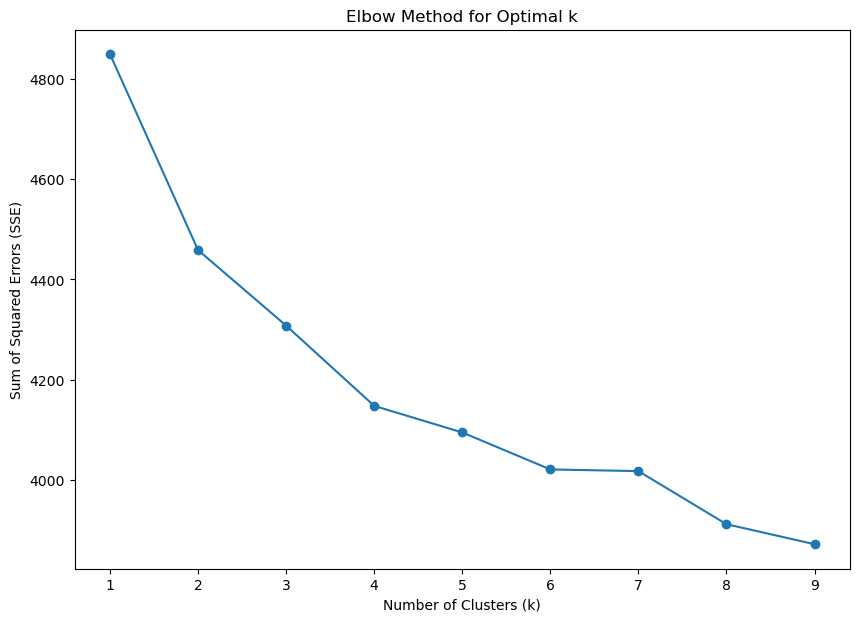

In [1120]:
#Elbow Method
sse = []
k_values = range(1, 10)  # 클러스터 개수 1에서 9까지 실험

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # SSE 값을 추가

# 3. Elbow Plot
plt.figure(figsize=(10, 7))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()

In [1124]:
# 1. TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df['text'].apply(lambda x: ' '.join(x)))

# 2. K-Means Clustering
num_clusters = 4  # 원하는 클러스터 수
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 3. 결과 시각화 (PCA로 차원 축소)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Text Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# 4. 클러스터링 결과 출력
print(df[['text', 'cluster']])

ValueError: empty vocabulary; perhaps the documents only contain stop words


Cluster 0 Top Terms:
[('bad', 122), ('experience', 34), ('cool', 32), ('installation', 16), ('cooling', 9), ('good', 9), ('problem', 8), ('technician', 8), ('low', 8), ('recommend', 8)]

Cluster 1 Top Terms:
[('buy', 182), ('ac', 139), ('cool', 124), ('money', 116), ('waste', 83), ('bad', 67), ('quality', 48), ('please', 41), ('good', 41), ('work', 40)]

Cluster 2 Top Terms:
[('good', 107), ('cool', 17), ('even', 8), ('degree', 8), ('installation', 5), ('go', 4), ('ac', 4), ('cooling', 3), ('feature', 3), ('also', 3)]

Cluster 3 Top Terms:
[('cool', 418), ('ac', 406), ('installation', 204), ('room', 168), ('good', 154), ('bad', 144), ('time', 118), ('unit', 114), ('service', 113), ('even', 111)]


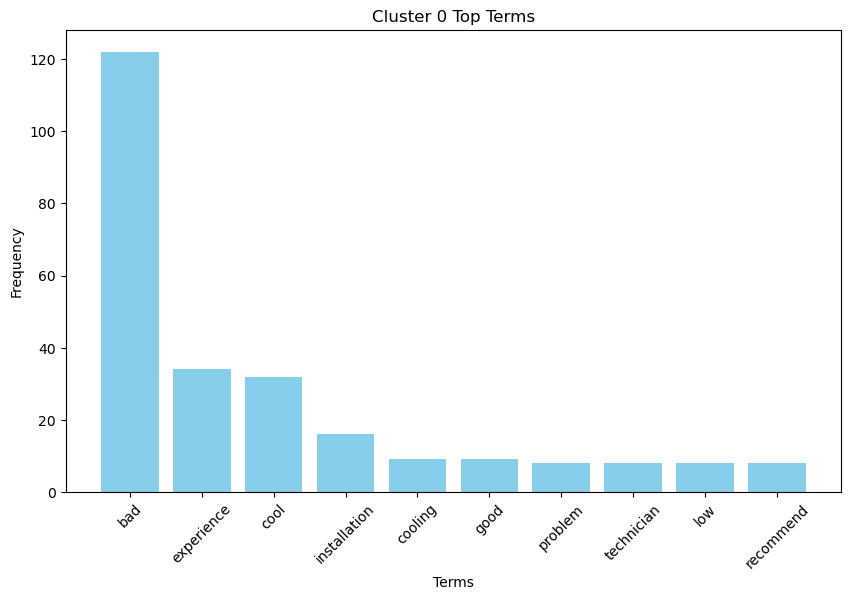

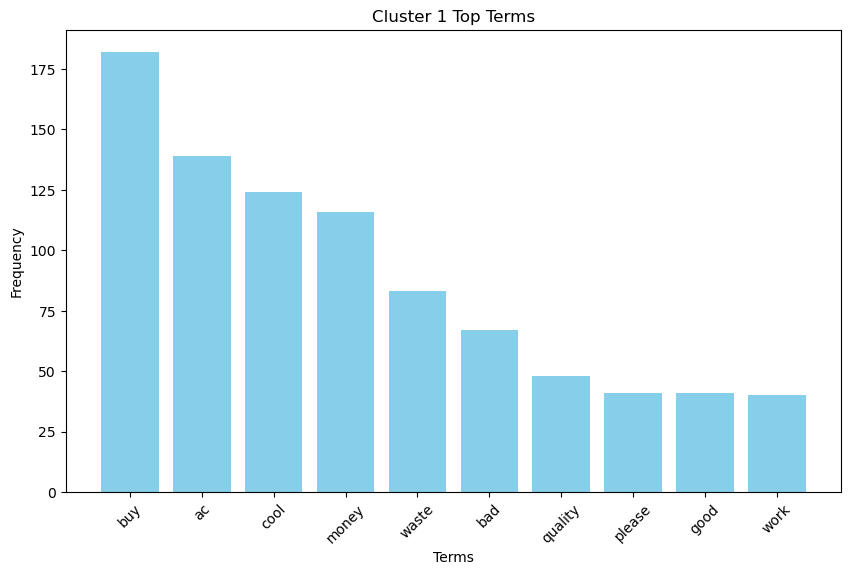

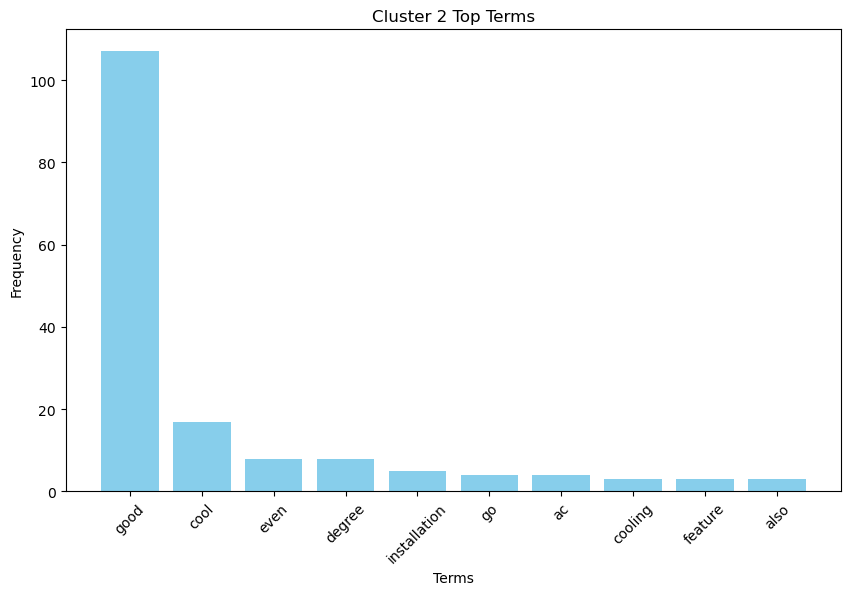

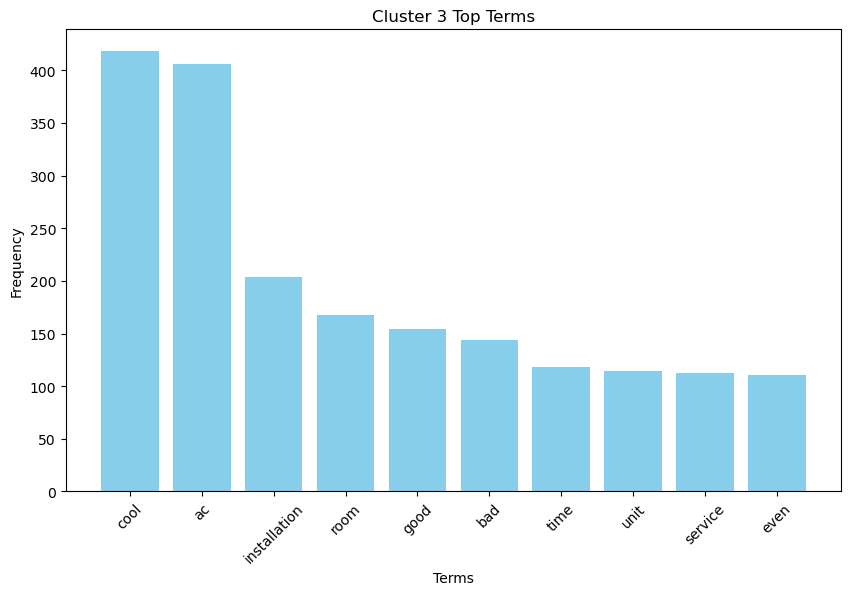

In [1122]:
# 'text' 컬럼을 리스트에서 문자열로 변환
df['text'] = df['text'].apply(lambda x: ' '.join(x))

# 4. 각 클러스터별 단어 빈도 계산
terms = tfidf_vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# 5. 각 클러스터별 상위 단어 추출 및 빈도수 계산
def get_top_terms_per_cluster(num_terms=10):
    cluster_term_dict = {}
    
    for cluster_num in range(4):
        print(f"\nCluster {cluster_num} Top Terms:")
        cluster_docs = df[df['cluster'] == cluster_num]['text']  # 클러스터에 속한 문서들
        term_counts = {}
        
        for doc in cluster_docs:
            for term in doc.split():  # 문자열을 단어로 나누기
                if term in term_counts:
                    term_counts[term] += 1
                else:
                    term_counts[term] = 1
        
        top_terms = sorted(term_counts.items(), key=lambda item: item[1], reverse=True)[:num_terms]
        cluster_term_dict[cluster_num] = top_terms
        print(top_terms)
    
    return cluster_term_dict

top_terms_per_cluster = get_top_terms_per_cluster(num_terms=10)

# 6. 클러스터별 상위 단어 바 그래프
def plot_top_terms_per_cluster(cluster_term_dict):
    for cluster_num, terms in cluster_term_dict.items():
        terms, frequencies = zip(*terms)  # 단어와 빈도를 분리
        
        plt.figure(figsize=(10, 6))
        plt.bar(terms, frequencies, color='skyblue')
        plt.title(f'Cluster {cluster_num} Top Terms')
        plt.xlabel('Terms')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

plot_top_terms_per_cluster(top_terms_per_cluster)

In [1123]:
df.head()

,text,star,hp_data,city,transformed_date,product_num,state,cluster
0,waste money ac work till one month installatio...,1,"[ai, convertible, cooling, model, ton, star, s...",[alwar],[may],"[tsqjnxe, copper, condenser]",[alwar],1
1,purchase april horrible experience ever work e...,1,"[ai, convertible, cooling, model, ton, star, s...",[kalyan],[apr],"[tsqjnxe, copper, condenser]",[kalyan],3
2,want buy white showpiece bedroom go ahead othe...,1,"[ai, convertible, cooling, model, ton, star, s...",[madhyamgram],[apr],"[tsqjnxe, copper, condenser]",[madhyamgram],3
3,totally waste money company refund money per p...,1,"[ai, convertible, cooling, model, ton, star, s...","[charkhi, dadri]",[may],"[tsqjnxe, copper, condenser]","[charkhi, dadri]",1
4,model way swing actual ton cooling capacity ch...,1,"[ai, convertible, cooling, model, ton, star, s...",[erode],[feb],"[tsqjnxe, copper, condenser]",[erode],3
